# Deep Learning Interpretability examples
---
In this notebook, we will train a very simple CNN to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database. We will then use this CNN to show several interpretability methods.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model
5. Perform Attribution with the model for some images
6. more stuff to come

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [1]:
import torch, copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

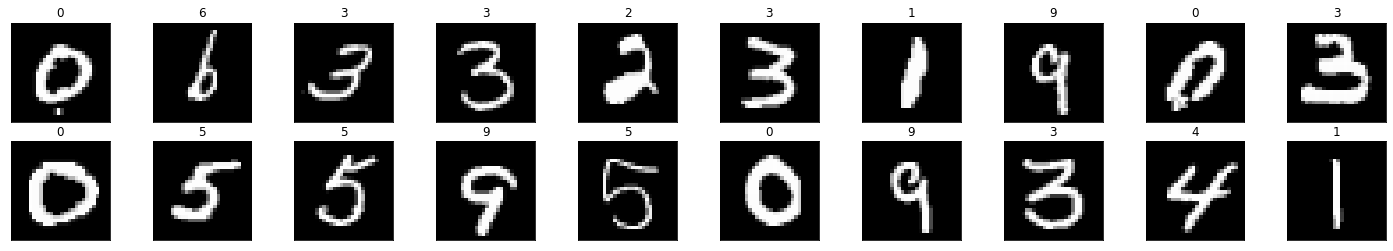

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

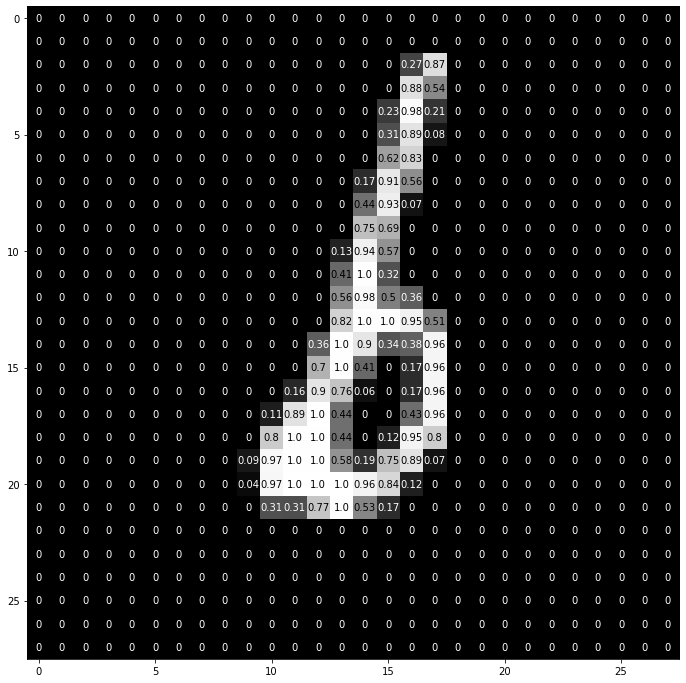

In [4]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [5]:
np.squeeze(images[1]).shape

(28, 28)

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

We want a very very simple CNN so it is fast and easy to use the explainations for. Let's get inspired by VGG with a mini-VGG

In [119]:
# define the NN architecture
class miniVGG(nn.Module):
    def __init__(self):
        super(miniVGG, self).__init__()
        # 28 x 28
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # 14 x 14
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 96, 3, padding=1)
        # 8 x 8
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(96, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 160, 3, padding=1)
        # 4 x 4
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv7 = nn.Conv2d(160, 192, 3, padding=1)
        self.conv8 = nn.Conv2d(192, 224, 3, padding=1)
        # 1 x 1
        self.pool4 = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(224, 100)
        self.fc2 = nn.Linear(100, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        
        self.layers = [self.conv1, self.conv2, self.pool1, 
                       self.conv3, self.conv4, self.pool2, 
                       self.conv5, self.conv6, self.pool3,
                       self.conv7, self.conv8, self.pool4, 
                       self.fc1, self.fc2]
        
        self.return_intermediates = True

    def forward(self, x):
        intermediates = []
        def vgg_block(xin, c1, c2, pool):
            xin1 = F.relu(c1(xin))
            xin2 = self.dropout(xin1)
            xin3 = F.relu(c2(xin2))
            xin4 = self.dropout(xin3)
            xin5 = self.pool1(xin4)
            intermediates_ = [xin1, xin2, xin3, xin4, xin5]
            return xin5, intermediates_
        x, i = vgg_block(x, self.conv1, self.conv2, self.pool1)
        intermediates += i
        x, i = vgg_block(x, self.conv3, self.conv4, self.pool2)
        intermediates += i
        x, i = vgg_block(x, self.conv5, self.conv6, self.pool3)
        intermediates += i
        x, i = vgg_block(x, self.conv7, self.conv8, self.pool4)
        intermediates += i
        x = x.view(-1, 224)
        intermediates += [x]
        x = self.dropout(F.relu(self.fc1(x)))
        intermediates += [x]
        x = F.relu(self.fc2(x))
        ### TODO: add the interpediate x's so I can later visualise the filters impact
        if self.return_intermediates:
            return x, intermediates
        else:
            return x

In [120]:
model = miniVGG()

In [121]:
model

miniVGG(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(160, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(192, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=224, out_features=100, bia

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 50 epochs; take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [10]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [122]:
model = model.cuda()

In [14]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    if epoch == 4:
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    if epoch == 10:
        optimizer = optim.SGD(model.parameters(), lr=0.001)
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output, _ = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output, _ = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_mnist.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.052450 	Validation Loss: 0.070551
Validation loss decreased (inf --> 0.070551).  Saving model ...
Epoch: 2 	Training Loss: 0.048766 	Validation Loss: 0.063681
Validation loss decreased (0.070551 --> 0.063681).  Saving model ...
Epoch: 3 	Training Loss: 0.046122 	Validation Loss: 0.058042
Validation loss decreased (0.063681 --> 0.058042).  Saving model ...
Epoch: 4 	Training Loss: 0.043079 	Validation Loss: 0.061089
Epoch: 5 	Training Loss: 0.039841 	Validation Loss: 0.056707
Validation loss decreased (0.058042 --> 0.056707).  Saving model ...
Epoch: 6 	Training Loss: 0.037554 	Validation Loss: 0.053982
Validation loss decreased (0.056707 --> 0.053982).  Saving model ...
Epoch: 7 	Training Loss: 0.036267 	Validation Loss: 0.051475
Validation loss decreased (0.053982 --> 0.051475).  Saving model ...
Epoch: 8 	Training Loss: 0.034332 	Validation Loss: 0.058604
Epoch: 9 	Training Loss: 0.032358 	Validation Loss: 0.041478
Validation loss decreased (0.051475 --> 0.

###  Load the Model with the Lowest Validation Loss

In [123]:
model.load_state_dict(torch.load('model_mnist.pt'))

<All keys matched successfully>

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [13]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation
model.return_intermediates = False

for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.028998

Test Accuracy of     0: 99% (977/980)
Test Accuracy of     1: 100% (1135/1135)
Test Accuracy of     2: 99% (1026/1032)
Test Accuracy of     3: 99% (1008/1010)
Test Accuracy of     4: 98% (972/982)
Test Accuracy of     5: 98% (883/892)
Test Accuracy of     6: 98% (948/958)
Test Accuracy of     7: 98% (1014/1028)
Test Accuracy of     8: 99% (970/974)
Test Accuracy of     9: 99% (1001/1009)

Test Accuracy (Overall): 99% (9934/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

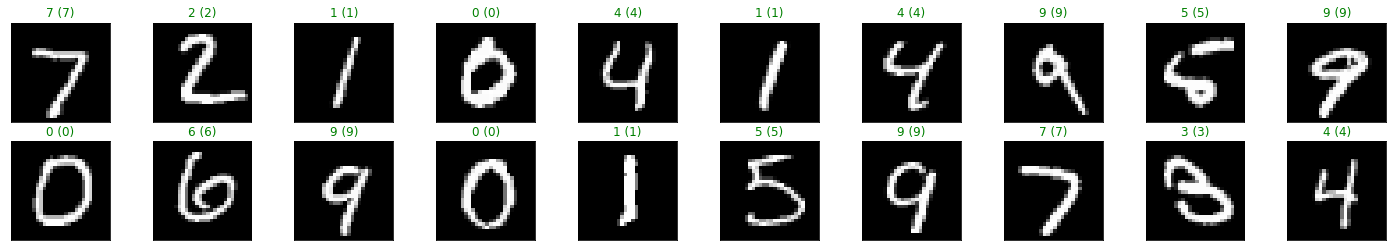

In [16]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
if train_on_gpu:
    images, labels = images.cuda(), labels.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
if train_on_gpu:
    images = images.cpu()
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

---
# Visualise *where* the Network looks for it's decisions:



In [18]:
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

In [22]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
if train_on_gpu:
    images, labels = images.cuda(), labels.cuda()

In [47]:
labels[0].cpu()

tensor(7)

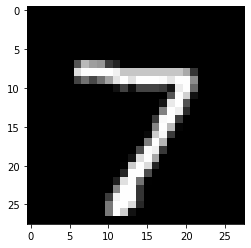

In [23]:
plt.imshow(np.squeeze(images[0].cpu()), cmap='gray')

In [79]:
model.eval() # prep model for evaluation
model.return_intermediates = False
img = images[0].unsqueeze(0)
print(img.shape)
ig = IntegratedGradients(model)
attribution = ig.attribute(img, target=labels[0])
print(attribution.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


(28, 28, 3) (28, 28, 3)


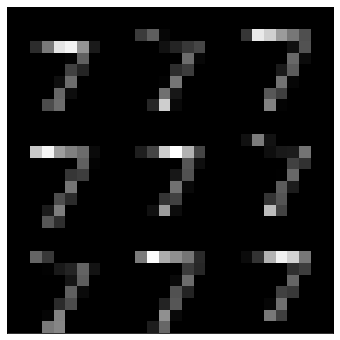

In [96]:
color_attr = attribution.squeeze(0)
color_attr = color_attr.repeat(3, 1, 1).cpu().numpy()

color_img = images[0]
color_img = color_img.repeat(3, 1, 1).cpu().numpy() #.cpu().numpy()

color_attr = color_attr.reshape(28,28,3) 
color_img = color_img.reshape(28,28,3) # np.rollaxis(color_img, 0, 2) 
print(color_attr.shape, color_img.shape)

res = viz.visualize_image_attr(color_attr, color_img, "blended_heat_map", cmap='gray')


---
# Visualise *what* template the Network looks for:


In [98]:
from max_act import maximize_im, maximize_im_simple

In [99]:
im = torch.zeros(img.shape, requires_grad=True, device='cuda')
ims_opt, losses = maximize_im_simple(model, im, class_num=7, lr=1e-5,
                                     num_iters=int(1e3), lambda_tv=1e-1, lambda_pnorm=1e-1)

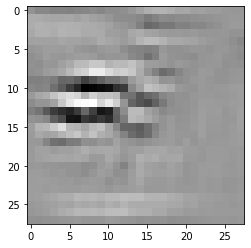

In [101]:
plt.imshow(np.squeeze(ims_opt[0].cpu()), cmap='gray')

---
# Visualise *how* the network transforms it's images

In [124]:
model.eval() # prep model for evaluation
model.return_intermediates = True
img = images[0].unsqueeze(0)
print(img.shape)
output, intermediates = model(img)
print(len(intermediates))

torch.Size([1, 1, 28, 28])
22


In [125]:
intermediates[0].shape

torch.Size([1, 16, 28, 28])

In [127]:
# move that to CPU and visualise some results:
activations = intermediates[0].squeeze().cpu().detach().numpy()

In [130]:
activations.shape

(16, 28, 28)

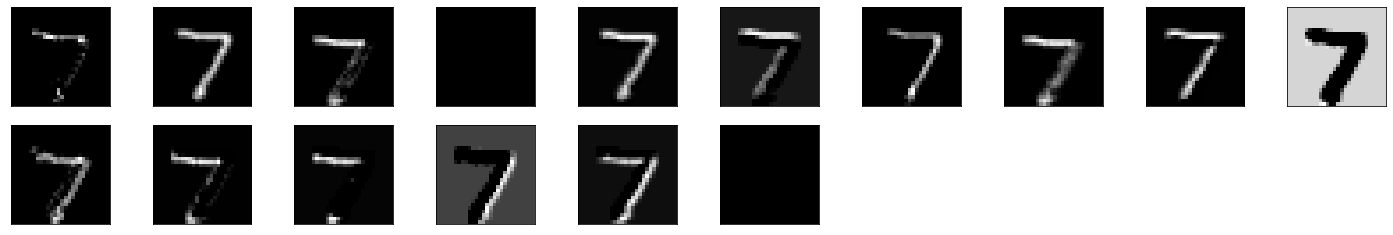

In [131]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(activations[idx], cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor